<a href="https://colab.research.google.com/github/jansoe/AICA/blob/main/GANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generative Adversial Networks

GANs, bei denen ein *generatives* Netz versucht, ein *diskriminatives* Netz auszutricksen.

In [ ]:
import tensorflow as tf
# Es lohnt sich zu überprüfen, ob man auch wirklich eine GPU bekommen hat.
print("Anzahl der zugewiesenen GPUs:", len(tf.config.list_physical_devices('GPU')))

Anzahl der zugewiesenen GPUs: 1


In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from IPython import display

Mit den Autoencodern haben Sie Ihr bereits eine Art von generativem Netz erstellt. Eine weitere Klasse von generativen Algorithmen sind die sogenannten *Generative Adversarial Networks*. 

Bei dieser Technik handelt es sich um zwei Netzwerke, die gegeneinander ausgespielt werden. Ein *generatives* Netzwerk erstellt künstliche Bilder, während ein *diskriminatives* Netzwerk zu klassifizieren versucht, ob ein Bild aus einem Trainingsset von *echten* Bildern stammt oder vom generativen Netzwerk erzeugt wurde. Die beiden Netzwerke werden dabei gleichzeitig trainiert und schaukeln sich gegenseitig hoch.

Ein typisches Beispiel aus der Popkultur sind [künstlich generierte, fotorealistische Bilder von Menschen, die es nicht gibt](https://this-person-does-not-exist.com/en).

### Datensatz für ein Anwendungsbeispiel

Das Trainieren von GANs auf echten Bilddaten ist sehr rechenintensiv und auch komplizierter. Zur Illustration des Prinzips benutzen wir deshalb wieder den MNIST-Datensatz.

In [ ]:
# Herunterladen des Datensatzes
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
# Hinzufügen einer weiteren Dimension für Convolutional Networks
train_images = train_images[:,:,:,np.newaxis].astype('float32')

# Normalize the images to [-1, 1]
train_images_gan = (train_images - 127.5) / 127.5

In [ ]:
# Hier erstellen wir ein Objekt, das die Portionierung der Daten während des Trainings handhabt.
train_dataset = tf.data.Dataset.from_tensor_slices(train_images_gan)

### Das Generator Modell

Analog zum Generator im Autoencoder erstellen wir hier auch wieder ein Modell, das aus einem kompakten Eingabecode Ausgabebilder erzeugt. Die Anzahl der Dimensionen der zugehörigen latenten Variable setzen wir diesmal jedoch auf 100.

In [ ]:
noise_dim = 8

generator = tf.keras.Sequential()

generator.add(layers.Dense(7*7*256, use_bias=False, input_shape=(noise_dim,)))
generator.add(layers.BatchNormalization())
generator.add(layers.LeakyReLU())

generator.add(layers.Reshape((7, 7, 256)))

generator.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=1, padding='same', use_bias=False))
generator.add(layers.BatchNormalization())
generator.add(layers.LeakyReLU())

generator.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=2, padding='same', use_bias=False))
generator.add(layers.BatchNormalization())
generator.add(layers.LeakyReLU())

generator.add(layers.Conv2DTranspose(1, kernel_size=(5, 5), strides=2, padding='same', use_bias=False, activation='tanh'))

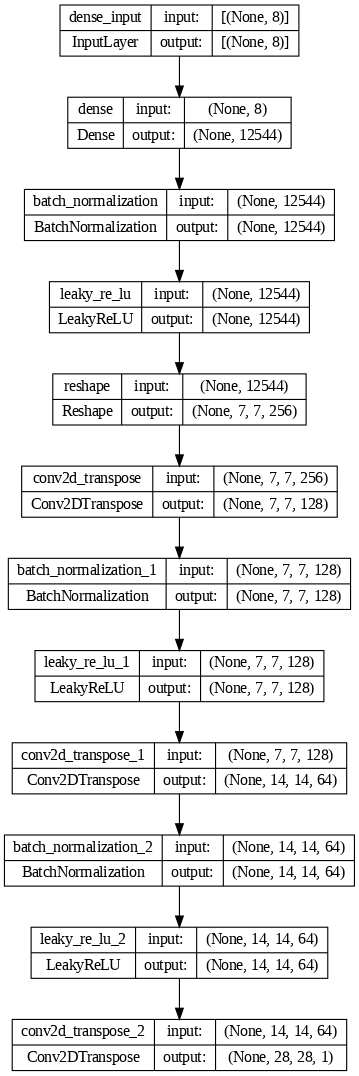

In [ ]:
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=80)

Wie zuvor können wir den Generator mit Rauschen füttern. Da er noch nicht trainiert ist, bekommen wir auch nur Rauschen zurück:

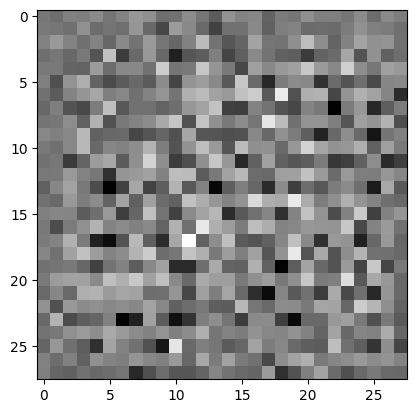

In [ ]:
np.random.seed(42)
noise = tf.random.normal([1, noise_dim])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

### Der Diskriminator

Der Diskriminator ist ein einfaches Klassifikationsnetz, wie wir es bereits aus vorangegangenen Aufgaben kennen.

In [ ]:
discriminator = tf.keras.Sequential()
discriminator.add(layers.Conv2D(64, (5, 5), strides=2, padding='same', input_shape=[28, 28, 1]))
discriminator.add(layers.LeakyReLU())
discriminator.add(layers.Dropout(0.3))

discriminator.add(layers.Conv2D(128, (5, 5), strides=2, padding='same'))
discriminator.add(layers.LeakyReLU())
discriminator.add(layers.Dropout(0.3))

discriminator.add(layers.Flatten())
discriminator.add(layers.Dense(1))

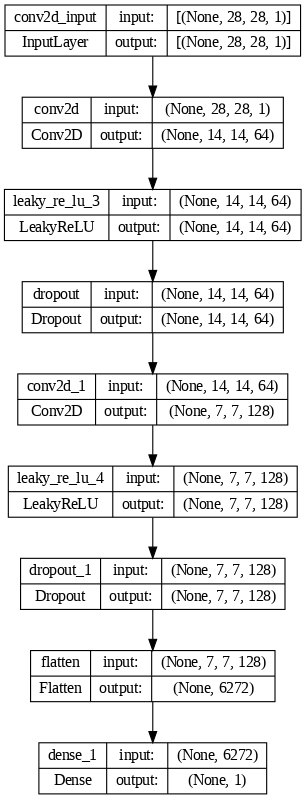

In [ ]:
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=80)

Um zu sehen, ob wir die Dimensionen richtig hinbekommen haben, generieren wir eine Vorhersage für das eben generierte Bild.

In [ ]:
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.00030805]], shape=(1, 1), dtype=float32)


Zur Kontrolle füttern wir dem Modell nun noch eines der echten Bilder.

In [ ]:
decision = discriminator(train_images[:1])
print(decision)

tf.Tensor([[10.670707]], shape=(1, 1), dtype=float32)


Der Diskriminator funktioniert, ist sich aber aufgrund seiner Unerfahrenheit noch unsicher, was wir von ihm wollen.

### Fehlerdefinition

Bisher haben wir zwei Netzwerke erstellt, zwischen denen noch kein Zusammenhang besteht. Dieser wird durch die Berechnung der Fehler hergestellt. Hierfür ist es hilfreich, zunächst den grundsätzlichen Ablauf des Trainings kennenzulernen.

In jedem Trainingsschritt wird für ein Batch (also eine kleine Portion) von "echten" Bildern (Bilder des Trainingsdatensatzes) zunächt ein gleichgroßer Stapel "falscher" Bilder vom Generator erzeugt (`g_out`). Für beide Arten von Bildern - das "reale" Bild des Trainingsdatensatzes und das generierte Bild - werden Antworten des Diskriminator-Netzwerks errechnet (`d_out_real`, `d_out_gen`). Aus dieser Vorhersage wird dann für beide Netze ein Fehler und damit eine Gewichtsveränderung zur Minimierung des jeweiligen Fehlers berechnet:

**Generator**:
- `1 - d_out_gen`: Je niedriger der Diskriminator auf das generierte Bild reagiert, desto größer der Fehler des Generators.

**Diskriminator**: (Der Fehler des Diskriminators ergibt sich aus zwei Werten)
- `1 - d_out_train`: Je niedriger der Output für die Bilder des Trainingsdatensatzes, desto höher ist der Fehler.
- `d_out_gen`: Je höher der Output für die Bilder des Generators, desto höher ist der Fehler.

Da die Fehlerart von Generator und Diskriminator die gleiche wie bei einem gewöhnlichen binären Klassifikationsproblem ist, können wir diese für beide gemeinsam definieren:

In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

Die Fehlerfunktion des Generators wird wie beschreiben auf dem Output des Diskriminators berechnet. Ziel des Generators ist es, den Diskriminator davon zu überzeugen, dass alle seine Bilder *einsen* sind:

In [ ]:
# Der Generator soll künstliche Bilder produzieren, so dass der Diskriminator den Generator-Output mit möglichst hoher Wahrscheinlichkeit als echt klassifiziert 
def generator_loss(d_out_gen):
    generator_loss = cross_entropy(tf.ones_like(d_out_gen), d_out_gen)
    return generator_loss

Der Diskriminator soll lernen, die Wahrscheinlichkeit dafür auszugeben, dass ein Bild "echt", d.h. nicht generiert ist. Er reagiert also idealerweise mit einer 1 auf ein Bild des Trainingsdatensatzen und mit einer 0 auf ein vom Generator-Netzwerk generiertes Bild.

In [ ]:
def discriminator_loss(d_out_real, d_out_gen):
    real_loss = cross_entropy(tf.ones_like(d_out_real), d_out_real)
    fake_loss = cross_entropy(tf.zeros_like(d_out_gen), d_out_gen)
    discriminator_loss = real_loss + fake_loss
    return discriminator_loss

Nun optimieren wir abwechseld den Discriminator und Generator

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

@tf.function # mit diesem Zusatz können wir das Training etwas beschleunigen
def train_step(images):
    
    noise = tf.random.normal([images.shape[0], noise_dim])
    # Trainings des Diskriminators
    with tf.GradientTape() as disc_tape:
        generator_out = generator(noise, training=False)
        discriminator_out_real = discriminator(images, training=True)
        discriminator_out_generated = discriminator(generator_out, training=True)

        disc_loss = discriminator_loss(discriminator_out_real, discriminator_out_generated)

    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    # Training des Generators
    with tf.GradientTape() as gen_tape:
        generator_out = generator(noise, training=True)
        discriminator_out_generated = discriminator(generator_out, training=False)

        gen_loss = generator_loss(discriminator_out_generated)
        
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

Wir generieren uns einige Werte für die latente Variable, um den Trainingsfortschritt zu visualisieren: 

In [ ]:
# We will reuse these random codes overtime to visualize progress during training
test_input = tf.random.normal([16, noise_dim])

In [ ]:
#@title
#@markdown Bitte ausführen: Code zum Visualisieren des Trainings

def generate_and_show_images(model, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode
  # dropouts: rescaled and no dropout
  # batchnorm: frozen
  # other layers: weights frozen
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.show()


Dann beginnt die eigentliche Trainingsschleife:

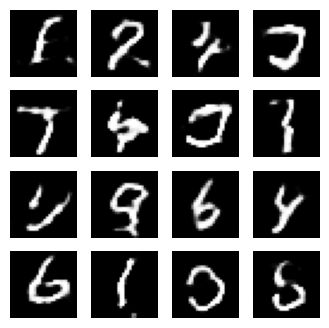

Time for epoch 50 is 13.650860071182251 sec


In [ ]:
train_dataset = train_dataset.shuffle(60000)
train_dataset = train_dataset.batch(256)

for epoch in range(50):
    start = time.time()

    for image_batch in train_dataset:
        train_step(image_batch)

    # Produce images as we go
    display.clear_output(wait=True)
    generate_and_show_images(generator, test_input)

    print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

### Ergebnis

Nach einigen Iterationen erzeugt der Generator Bilder, die wie handgeschriebene Zahlen oder zumindest Symbole aussehen. Beim Autoencoder bildeten sich bestimmte Bereiche im latenten Raum heraus, an denen einzelne Ziffern repräsentiert werden. Diese Bereiche konnten wir finden, indem wir sie mit dem Encoder *aktivieren*. Beim Generator der GANs ist das nicht mehr möglich - er generiert zufällige Bilder, ohne dass wir direkten Einfluss nehmen können. 

Generieren Wir zum Spaß also noch einige Zufallsbilder. 

1/1 [==============================] - 0s 25ms/step


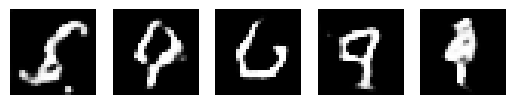

In [ ]:
for i in range(5):
    plt.subplot(1,5,i+1)
    random_code = np.random.randn(1, noise_dim) # zufälliger Code!
    image = generator.predict(random_code)
    plt.imshow(image.squeeze(), cmap='gray')
    plt.axis('off')

### Aufgabe: Größe des latenten Raumes

Im vorangegangenen Beispiel hatte unser latenter Raum eine Dimensionalität von 8 (Variable `latent_dim`), analog zum Autoencoder, der auch mit einer Code-Länge von acht Zahlen zurecht kam. Da es bei GANs nicht auf Kompression ankommt, wird hier oft ein vergleichsweise großer Raum gewählt, mit der Hoffnung, reichhaltigere Ergebnisse zu erziehlen. Verändern Sie die Variable `latent_dim` und führen Sie den Code ab dieser Zelle erneut aus und untersuchen Sie folgende Fragestellungen:

- Generiert das Modell für `latent_dim=100` wesentlich bessere Ergebnisse? 
- Generiert das Modell auch noch für `latent_dim=2` vernünftige Ergebnisse?
- Ab welcher Größe funktioniert es kaum noch?

### Aufgabe: Morphing

Beim Autoencoder haben Sie gesehen, wie wir aus zufälligen Codes Bilder generieren können. Kopieren Sie den Code zum Morphen zwischen Bildern des Autoencoders und modifizieren Sie ihn so, dass zwischen zwei zufällig generierten Codes des GAN-Generators gemorpht wird.